# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

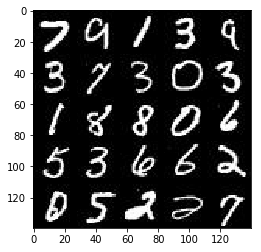

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

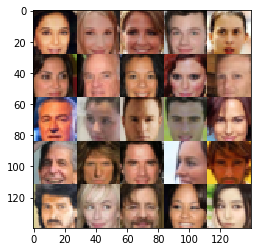

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learn_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # layer 1
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        net = tf.maximum(alpha*net, net)
        
        # layer 2
        net = tf.layers.conv2d(net, 128, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha*net, net)
        
        # layer 3
        net = tf.layers.conv2d(net, 256, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(alpha*net, net)
        
        # layer 4
        flat = tf.reshape(net, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        
        # layer 1
        net = tf.layers.dense(z, 7*7*512)
        net = tf.reshape(net, (-1, 7, 7, 512))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha*net, net)
      
        # layer 2
        net = tf.layers.conv2d_transpose(net, 256, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha*net, net)
        
        # layer 3
        net = tf.layers.conv2d_transpose(net, 128, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha*net, net)
        
        # layer 4
        logits = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
                                labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    real_input, z_input, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)
    d_ops, g_ops = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    print_when = 10
    show_when = 50
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_images *= 2
                
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_ops, feed_dict={real_input: batch_images,\
                                               z_input: z_batch, learn_rate: learning_rate})
                
                _ = sess.run(g_ops, feed_dict={real_input: batch_images,\
                                               z_input: z_batch, learn_rate: learning_rate})
                
                if i % print_when == 0:
                        d_loss_train = d_loss.eval({
                            z_input: z_batch,
                            real_input: batch_images
                        })
                        g_loss_train = g_loss.eval({z_input: z_batch})
                        
                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(d_loss_train),
                              "Generator Loss: {:.4f}".format(g_loss_train))

                if i % show_when == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)
        saver.save(sess, 'gen.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 2.0515... Generator Loss: 0.2089
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 2.1347
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 0.7421


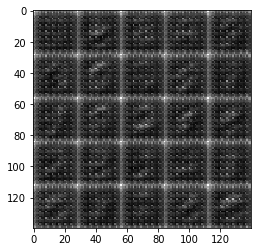

Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.5070... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.6996... Generator Loss: 0.3313
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.9687... Generator Loss: 0.2108


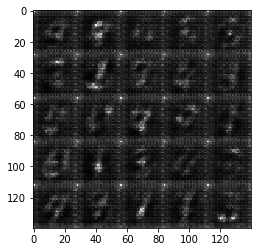

Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 1.3777
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 1.0228
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.3975
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.5792


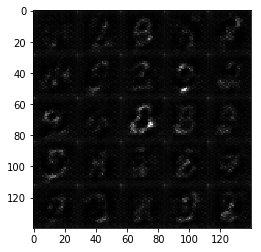

Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.4280
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 2.2029


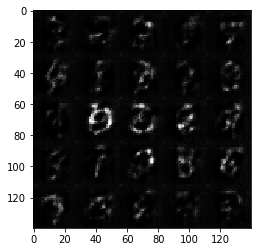

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.6971
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 1.7068


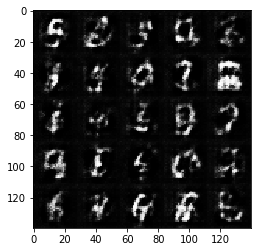

Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.6476
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 0.8581... Generator Loss: 1.3684
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.0389


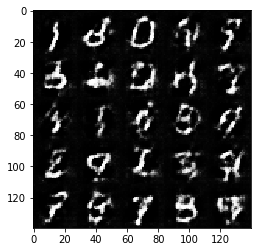

Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.0751
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.7512
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 1.4654


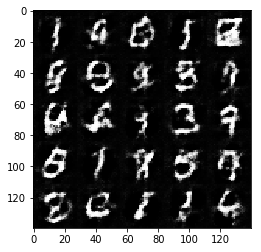

Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 2.0569
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 1.8454
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.8233


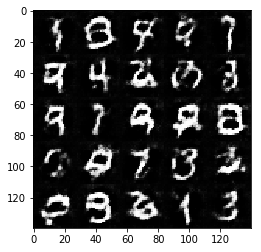

Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.6173


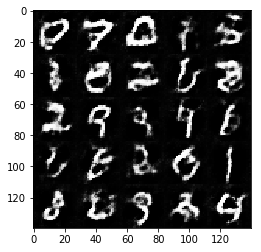

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.3816
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 1.6512
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.0472
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.4765


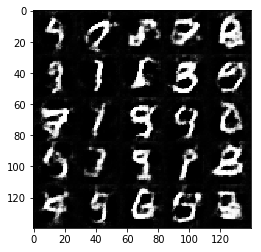

Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 1.5134
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 1.4359


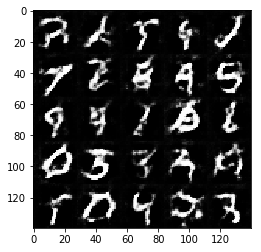

Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.0398
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.4614


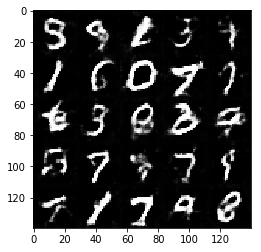

Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.2635
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 0.6750


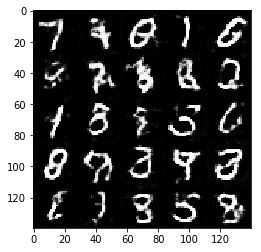

Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.5429
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.4171
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 0.9640


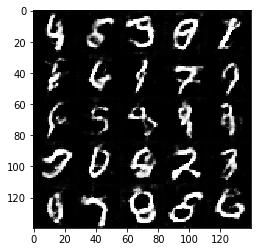

Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 2.1678
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 1.4064
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 0.8094


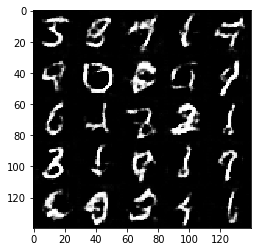

Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 0.8982... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 1.9673... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 0.8843


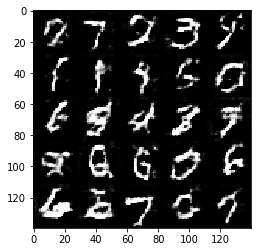

Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.5898


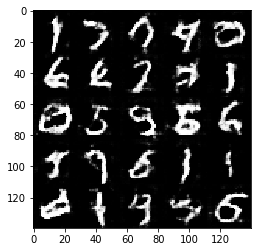

Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.3890
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.1176


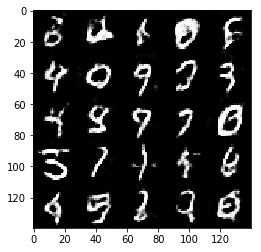

Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.5421
Epoch 2/2... Discriminator Loss: 0.8435... Generator Loss: 0.8335


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4325... Generator Loss: 0.2291
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.4981


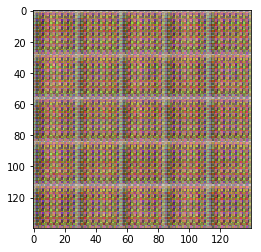

Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.6088
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 1.9474
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 2.9494
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.3473


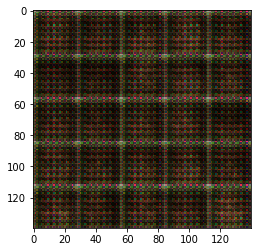

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.7983
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.7273


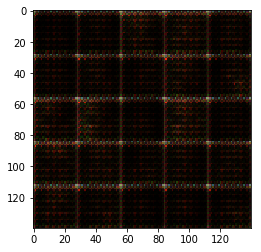

Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.2601
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8860


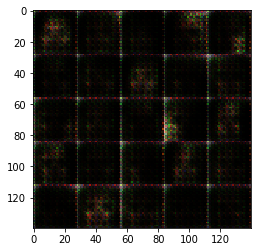

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0058


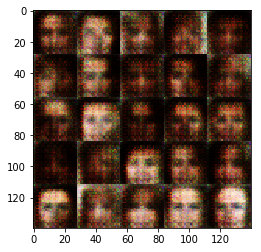

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.8092


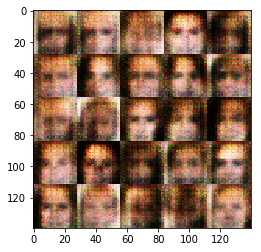

Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8102


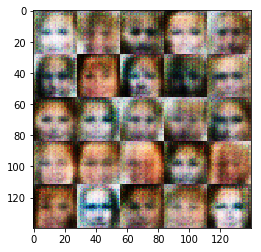

Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.4735


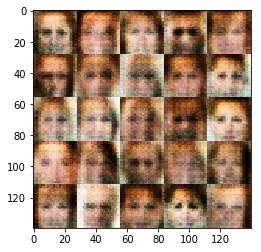

Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8206


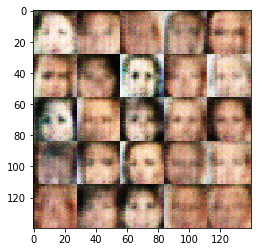

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.1637


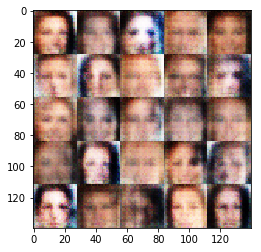

Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.2121
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5968


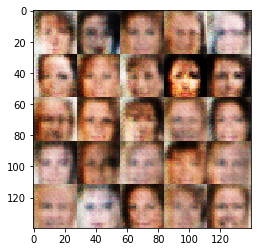

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8004


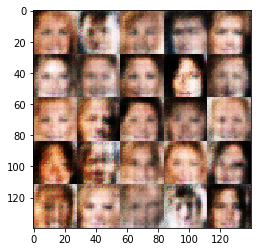

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8504


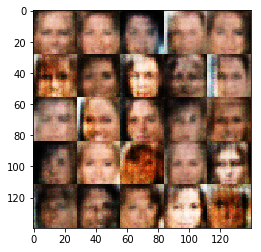

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.6783


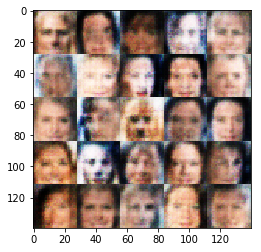

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8792


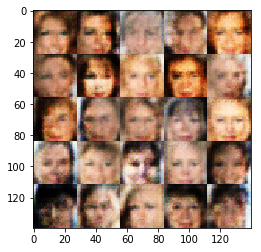

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9473


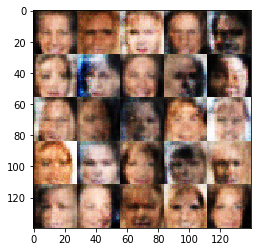

Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7822


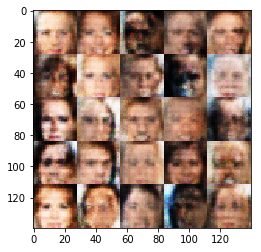

Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.9781


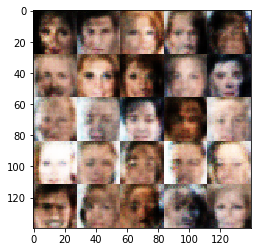

Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6265


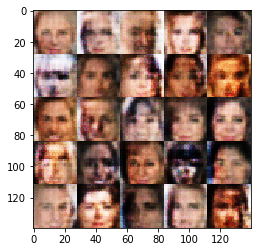

Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5306


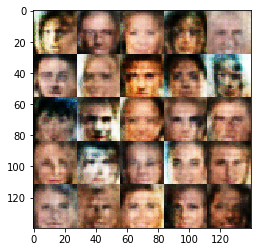

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.8303


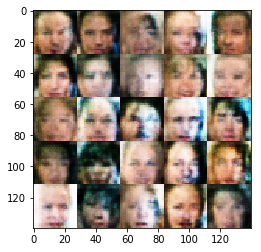

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6297


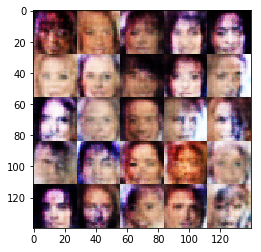

Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8601


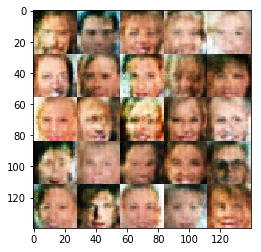

Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6142


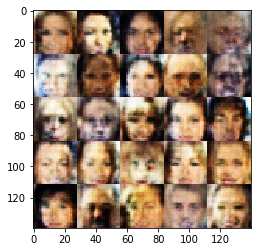

Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8960


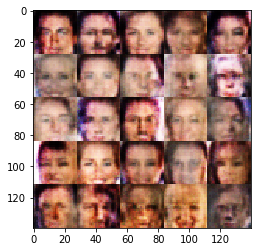

Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7935


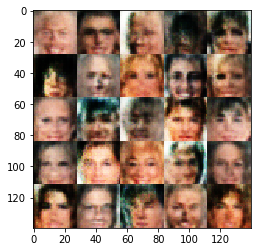

Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7402


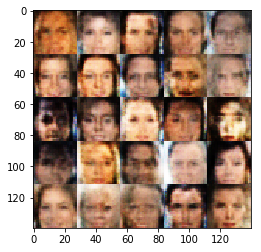

Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7988


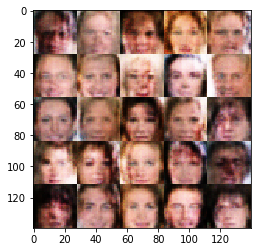

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7509


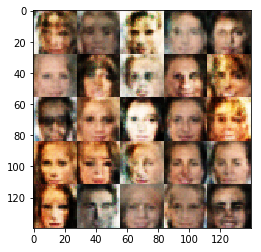

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6154


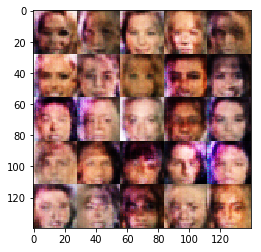

Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6591


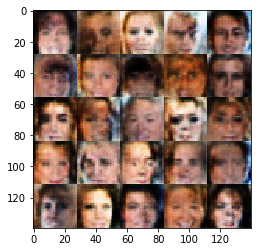

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6280


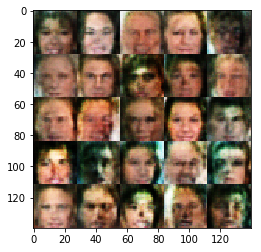

Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7592


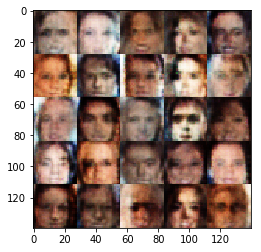

Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7444


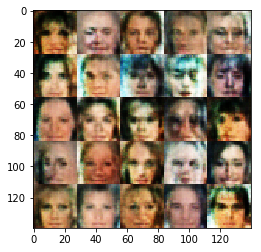

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8059


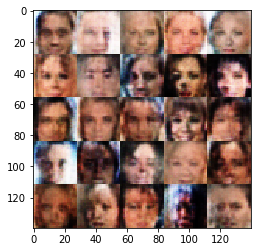

Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8454


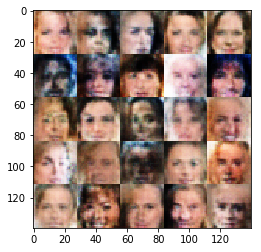

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7850


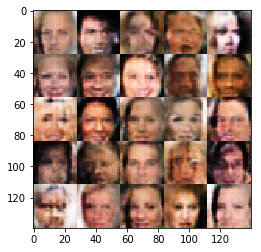

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8580


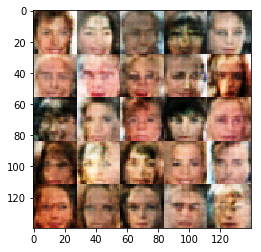

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8673


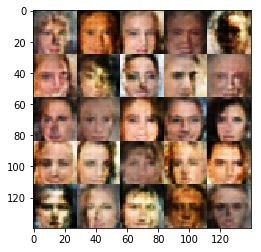

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.6424


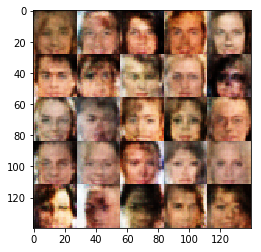

Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6123


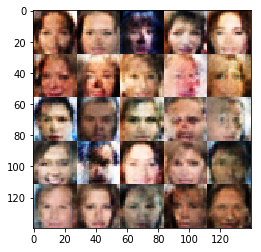

Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6999


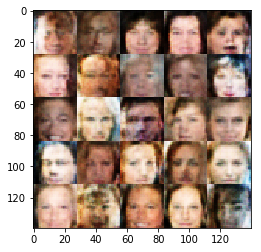

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7882


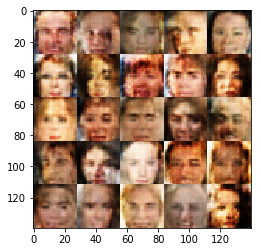

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5558


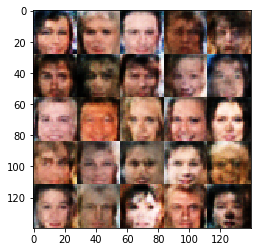

Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.8339


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.